In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# --- 1. Data Loading and Preprocessing ---
df = pd.read_csv('sanad.csv')

def clean_arabic_text(text):
    # 1. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 2. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # 3. Remove English/Latin characters and digits
    text = re.sub(r'[^\u0600-\u06FF\s]+', ' ', text)
    # 4. Remove diacritics
    arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(arabic_diacritics, '', text)
    # 5. Remove Tatweel (Kashida)
    text = re.sub(r'ـ', '', text)
    # 6. Normalize Alef variants
    text = re.sub(r'[أإآ]', 'ا', text)
    # 7. Normalize Taa Marbuta (ة) to Haa (ه) - Optional, but common for consistency
    text = re.sub(r'ة', 'ه', text)
    # 8. Remove punctuation
    punctuation_to_remove = r'[.,!?:؛،()\]\[{}<>"\'`~|/@#$%^&*_=+\-\\]'
    text = re.sub(punctuation_to_remove, ' ', text)
    # 9. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 10. Optional: Remove Arabic Stopwords
    arabic_stopwords = set(nltk.corpus.stopwords.words('arabic'))
    words = nltk.tokenize.word_tokenize(text)
    filtered_words = [word for word in words if word not in arabic_stopwords]
    text = ' '.join(filtered_words)
    return text

# Apply cleaning to the text column
df['cleaned_text'] = df['text'].apply(clean_arabic_text)

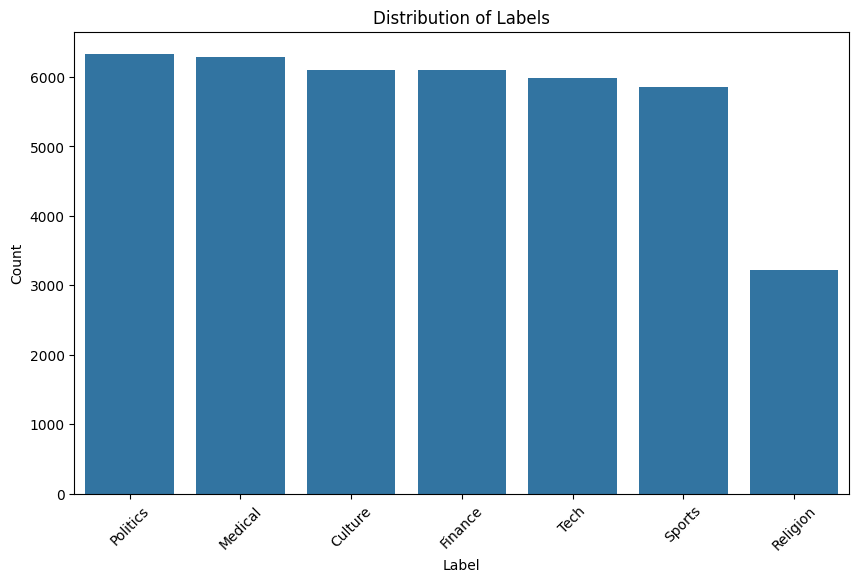

In [3]:
# Display distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

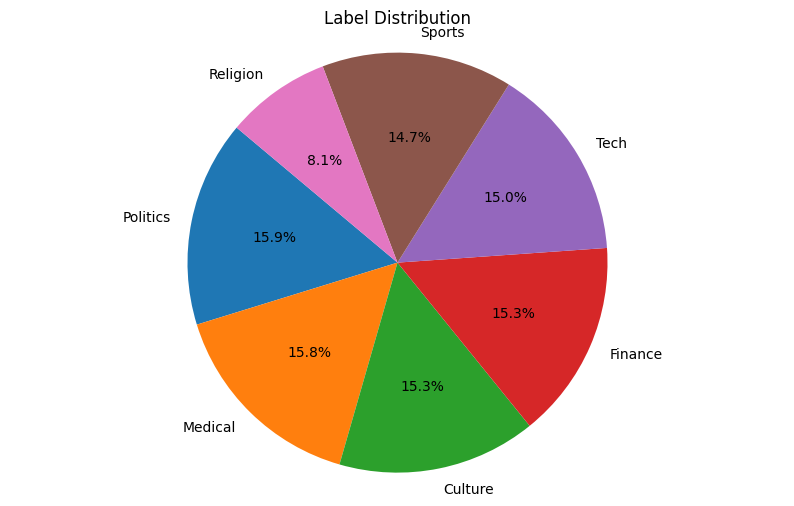

In [4]:
plt.figure(figsize=(10, 6))
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Label Distribution')
plt.axis('equal')
plt.show()

In [5]:
# Prepare data for model
X = df['cleaned_text']
y = df['label']

In [6]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [7]:
# Split data for training and testing
X_train_text, X_test_text, y_train_encoded, y_test_encoded = train_test_split(
    X.tolist(), y_encoded, test_size=0.2, random_state=42
)

In [8]:
# --- 2. BERT Model and Tokenizer Setup ---
model_name = 'asafaya/bert-base-arabic'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# We load the BERT model with a classification head, but we'll use its logits as features
# and ensure its weights are frozen during the SimpleNN training.
bert_model_for_embeddings = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# --- 3. Custom PyTorch Dataset ---
class ArabicTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [19]:
# Create Dataset and DataLoader instances
batch_size = 32
train_dataset = ArabicTextDataset(X_train_text, y_train_encoded, tokenizer)
test_dataset = ArabicTextDataset(X_test_text, y_test_encoded, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# --- 4. Simple Neural Network Classifier ---
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(torch.relu(self.fc3(x))) # Apply dropout after ReLU on fc3
        return self.output(x) # Removed log_softmax, as CrossEntropyLoss expects raw logits


# Determine input dimension for SimpleNN (based on BERT's output logits)
input_dim_nn = len(le.classes_) # Number of labels in your dataset
classifier_model = SimpleNN(input_dim=input_dim_nn, output_dim=len(le.classes_))



In [26]:
# --- 5. Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model_for_embeddings.to(device)
bert_model_for_embeddings.eval() # Set BERT to evaluation mode to freeze its weights

classifier_model.to(device)

criterion = nn.CrossEntropyLoss() # CrossEntropyLoss includes softmax internally
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

In [28]:
import time
from tqdm import tqdm
import torch

epochs = 10

for epoch in range(epochs):
    classifier_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    start_time = time.time()

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        optimizer.zero_grad()

        # Get BERT embeddings without tracking gradients for BERT itself
        with torch.inference_mode(): # Use inference_mode for BERT to save memory/speed
            bert_outputs = bert_model_for_embeddings(input_ids=input_ids, attention_mask=attention_mask)
            bert_features = bert_outputs.logits

        # CLONE the bert_features and enable gradient tracking for the classifier_model
        # This is the crucial change
        bert_features_for_nn = bert_features.clone().detach().requires_grad_(True)

        outputs = classifier_model(bert_features_for_nn) # Use the cloned tensor
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += labels.size(0)

    end_time = time.time()
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples
    epoch_duration = end_time - start_time

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Time: {epoch_duration:.2f}s")

    # --- Evaluation Phase ---
    classifier_model.eval()
    test_total_correct = 0
    test_total_samples = 0
    all_predictions = []
    all_true_labels = []

    with torch.inference_mode(): # Inference mode is correct for evaluation
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1} [Testing]"):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            bert_outputs = bert_model_for_embeddings(input_ids=input_ids, attention_mask=attention_mask)
            bert_features = bert_outputs.logits # No need to clone/detach here as no backward pass for classifier

            outputs = classifier_model(bert_features)
            predictions = outputs.argmax(dim=1)

            test_total_correct += (predictions == labels).sum().item()
            test_total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().tolist())
            all_true_labels.extend(labels.cpu().tolist())

    test_accuracy = test_total_correct / test_total_samples
    print(f"[Epoch {epoch+1}] Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10 [Training]:   8%|▊         | 77/998 [02:02<24:27,  1.59s/it]  


KeyboardInterrupt: 

In [ ]:
# --- 8. Final Evaluation Metrics ---
print("\n--- Classification Report ---")
print(classification_report(all_true_labels, all_predictions, target_names=le.classes_))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# --- 9. Save the trained classifier model ---
torch.save(classifier_model.state_dict(), 'arabic_text_classifier.pth')
print("\nClassifier model saved to 'arabic_text_classifier.pth'")


In [ ]:
# --- 10. Example Inference/Prediction Function ---
def predict_arabic_text(text, tokenizer, bert_model, classifier_model, label_encoder, device):
    cleaned_text = clean_arabic_text(text)
    
    # Generate BERT embedding
    inputs = tokenizer(cleaned_text, padding='max_length', truncation=True, return_tensors='pt', max_length=256)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    bert_model.eval() # Ensure BERT model is in eval mode
    with torch.no_grad():
        bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        bert_features = bert_outputs.logits # Get logits as features

    classifier_model.eval() # Ensure classifier is in eval mode
    with torch.no_grad():
        nn_outputs = classifier_model(bert_features)
        _, predicted_class_idx = torch.max(nn_outputs, 1)

    # Decode the predicted label
    predicted_label = label_encoder.inverse_transform(predicted_class_idx.cpu().numpy())
    return predicted_label[0]

In [ ]:
# Ensure you load the classifier model if running this separately
loaded_classifier_model = SimpleNN(input_dim=len(le.classes_), output_dim=len(le.classes_))
loaded_classifier_model.load_state_dict(torch.load('arabic_text_classifier.pth'))
loaded_classifier_model.to(device)


In [ ]:
new_text = "هذا نص تجريبي جميل جداً يتحدث عن الفن والثقافة."
predicted_category = predict_arabic_text(new_text, tokenizer, bert_model_for_embeddings, classifier_model, le, device)
print(f"\nPredicted category for '{new_text}': {predicted_category}")